In [1]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
from scipy.linalg import expm
from sklearn.metrics import f1_score
import cvxpy as cp
import random
from IPython.display import display
import time
import os
from joblib import Parallel, delayed

from src.model import Nonneg_dagma, MetMulDagma
import src.utils as utils

from colide.model import colide_ev

SEED = 10
N_CPUS = os.cpu_count() // 2

np.random.seed(SEED)
random.seed(SEED)

/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# def DAG_no_tears_cvx(X, stepsize, rho, lamb, A_true, iters_o=10, iters_i=25):
#     M, N = X.shape

#     # Init A and alpha
#     A_k = .1*np.ones((N,N))  # create_dag(N, .1)
#     alpha_k = .01

#     norm_A_true = la.norm(A_true)
#     errs_A = np.zeros(iters_o)
#     alphas_A = np.zeros(iters_o)
#     acyclicity = np.zeros(iters_o)
    
#     for i in range(iters_o):
#         # Primal update
#         Cx = X.T @ X
#         for _ in range(iters_i):
#             Gradient = 1 * Cx @(A_k - np.eye(N))
#             Gradient += (alpha_k + rho*(np.trace(expm(A_k)) - N))*expm(A_k).T
#             if np.any(np.isnan(Gradient)) or np.any(np.isinf(Gradient)):
#                 print('WARNING: gradient is NaN or Inf')
#                 break

#             A_k = np.maximum(np.abs(A_k - stepsize*Gradient) - lamb, 0)

#         for _ in range(iters_i):
#             alpha_k = alpha_k + rho*(np.trace(expm(A_k)) - N)
#             if np.any(np.isnan(alpha_k)) or np.any(np.isinf(alpha_k)):
#                 print(f'WARNING: alpha is NaN or Inf: {alpha_k}')
#                 break
        
#         alphas_A[i] = alpha_k
#         errs_A[i] = (la.norm(A_true - A_k)/norm_A_true)**2
#         acyclicity[i] = np.trace(expm(A_k)) - N

#     return A_k, alphas_A, errs_A, acyclicity


# def DAGMA_cvx(X, stepsize, mu0, descount, s, lamb, A_true, iters_o=10, iters_i=10):
#     M, N = X.shape

#     # Init A
#     mu_k = mu0
#     A_k = np.zeros((N,N))
#     Cx =  1 * X.T @ X

#     norm_A_true = la.norm(A_true)
#     errs_A = np.zeros(iters_o*iters_i)
#     acyclicity = np.zeros(iters_o*iters_i)
#     for i in range(iters_o):
#         for j in range(iters_i):
#             Gradient = mu_k * Cx @(A_k - np.eye(N)) + la.inv(s*np.eye(N) - A_k).T + lamb*np.ones_like(A_k)
#             A_k = np.maximum(A_k - stepsize*Gradient, 0)
   
#             idx = i*iters_i + j
#             errs_A[idx] = (la.norm(A_true - A_k)/norm_A_true)**2
#             acyclicity[idx] = N*np.log(s) - la.slogdet(s*np.eye(N) - A_k)[1]
        
#         mu_k *= descount
    
#     return A_k, errs_A, acyclicity


# def DAGMA_cvx_neg(X, stepsize, mu0, descount, s, lamb, A_true, iters_o=10, iters_i=10):
#     M, N = X.shape

#     # Init A
#     mu_k = mu0
#     A_k = np.zeros((N,N))
#     Cx =  1 * X.T @ X

#     norm_A_true = la.norm(A_true)
#     errs_A = np.zeros(iters_o*iters_i)
#     acyclicity = np.zeros(iters_o*iters_i)
#     for i in range(iters_o):
#         for j in range(iters_i):
#             Gradient = mu_k * Cx @(A_k - np.eye(N)) + la.inv(s*np.eye(N) - np.abs(A_k)).T*np.sign(A_k)
#             A_grad_step = A_k - stepsize*Gradient
#             A_k = np.maximum(np.abs(A_grad_step) - stepsize*lamb, 0) * np.sign(A_grad_step)
#             # A_k = np.maximum(A_grad_step - lamb, 0)
   
#             idx = i*iters_i + j
#             errs_A[idx] = (la.norm(A_true - A_k)/norm_A_true)**2
#             acyclicity[idx] = N*np.log(s) - la.slogdet(s*np.eye(N) - A_k)[1]
        
#         mu_k *= descount
    
#     return A_k, errs_A, acyclicity

In [3]:
def run_exps(g, data_p, exps, thr=.2, verb=False):
    A_true, _, X = utils.simulate_sem(**data_p)
    A_true_bin = utils.to_bin(A_true, thr)
    X_norm = X/la.norm(X, axis=1, keepdims=True)

    fidelity = 1/data_p['n_samples']*la.norm(X - X @ A_true, 'fro')**2
    fidelity_norm = 1/data_p['n_samples']*la.norm(X_norm - X_norm @ A_true, 'fro')**2

    print(f'{g}: Fidelity: {fidelity:.3f}  -  Fidelity (norm): {fidelity_norm:.3f}')

    shd, fscore, err, acyc, runtime = [np.zeros(len(exps))  for _ in range(5)]
    for i, exp in enumerate(exps):
        X_aux = X_norm if 'norm_x' in exp.keys() and exp['norm_x'] else X
        model = exp['model']()
        t_i = time.time()
        A_est = model.fit(X_aux, **exp['args'])
        t_solved = time.time() - t_i

        A_est = model.W_est

        A_est_bin = utils.to_bin(A_est, thr)
        shd[i], _, _ = utils.count_accuracy(A_true_bin, A_est_bin)
        fscore[i] = f1_score(A_true_bin.flatten(), A_est_bin.flatten())
        err[i] = utils.compute_norm_sq_err(A_true, A_est)
        acyc[i] = model.dagness(A_est) if hasattr(model, 'dagness') else 1
        runtime[i] = t_solved

        if verb:
            print(f'\t-{exp["leg"]}: shd {shd[i]}  -  err: {err[i]:.3f}  -  time: {runtime[i]:.3f}')

    return shd, fscore, err, acyc, runtime

def compute_errsW(W_seq, W_true):
    errs = np.zeros(len(W_seq))
    norm_W_true = la.norm(W_true)
    for i, W_est in enumerate(W_seq):
        errs[i] = (la.norm(W_true - W_est)/norm_W_true)**2
    
    return errs
    
def plot_result(A_true, A_est, thr, plot_matrices=True):
    # norm_A_true = la.norm(A_true)

    A_est_bin = utils.to_bin(A_est, thr)
    A_true_bin = utils.to_bin(A_true, thr)

    fro_err = utils.compute_norm_sq_err(A_true, A_est)
    fro_err_bin = utils.compute_norm_sq_err(A_true_bin, A_est_bin)
    sdh, _, _ = utils.count_accuracy(A_true_bin, A_est_bin)
    fscore = f1_score(A_true_bin.flatten(), A_est_bin.flatten())

    print(f'Err: {fro_err:.3f}  -  Err bin: {fro_err_bin:.3f}  -  shd: {sdh}  -  fscore: {fscore:.3f}')

    if plot_matrices:
        plt.figure(figsize=(8, 8))
        plt.subplot(2,2,1)
        plt.imshow(A_true)
        plt.colorbar()
        plt.title("A true")
        plt.subplot(2,2,2)
        plt.imshow(A_est)
        plt.colorbar()
        plt.title("A est")
        plt.subplot(2,2,3)
        plt.imshow(A_true_bin)
        plt.colorbar()
        plt.title("A true bin")
        plt.subplot(2,2,4)
        plt.imshow(A_est_bin)
        plt.colorbar()
        plt.title("A est bin")

def plot_convergence(model, W_true):

    errs_W = compute_errsW(model.seq_W, W_true)

    plt.figure(figsize=(12, 4))
    plt.subplot(1,3,1)
    plt.semilogy(model.diff)
    plt.title('Convergence of W')
    plt.subplot(1,3,2)
    plt.semilogy(errs_W)
    plt.title('Error')
    plt.subplot(1,3,3)
    plt.semilogy(model.acyclicity)
    plt.title('Acyclicity')
    plt.tight_layout()

## Quick comparisons

In [4]:
# DAG parameters
N = 50  # 50
g_type = 'er'
edges = N*2  #N*2
edge_type = 'positive'  # Options: binary, positive, weighted
w_range = (.5, 1)  #(.3, .9)
norm_x = False
M = 500

A, dag, X = utils.simulate_sem(N, M, g_type, edges, permute=False, edge_type=edge_type,
                               w_range=w_range, noise_type='normal', var=1/np.sqrt(N))

if norm_x:
    X = X/la.norm(X, axis=1, keepdims=True)

print(f'Mean degree: {(A.sum(axis=0).mean()):2f}')
print('Mean norm of X:', la.norm(X, axis=1).mean())
print('Fidelity error:', 1/M*la.norm(X - X @ A, 'fro')**2)


Mean degree: 1.702187
Mean norm of X: 6.854103250095126
Fidelity error: 7.051883412234961


### Proj Grad Descent DAGMA Alg

lamb: 0.0017690727526991413


Solved in 82.670944 seconds
Err: 0.029  -  Err bin: 0.018  -  shd: 1  -  fscore: 0.991


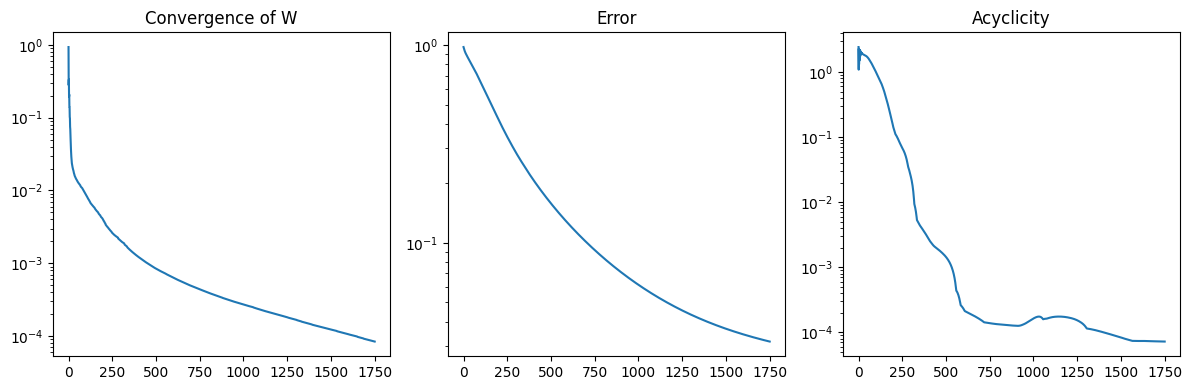

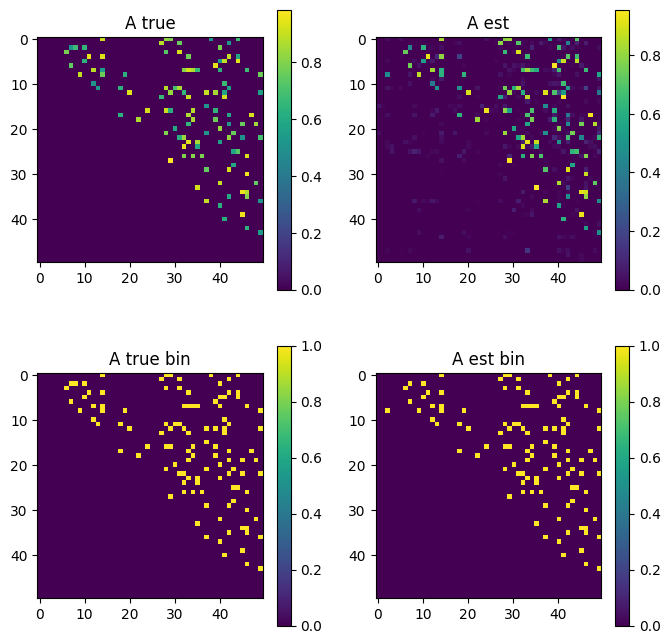

In [5]:
## Second set of hyperparams N = 50
args = {'stepsize': 5e-2, 'alpha': .5, 's': 1, 'lamb': np.sqrt(np.log(N)/M)*2e-2, 'max_iters': 10000}

print('lamb:', args['lamb'])

t_i = time.time()
model_ppgd = Nonneg_dagma()
A_dagma2 = model_ppgd.fit(X, **args, track_seq=True)
t_solved = time.time() - t_i
print(f'Solved in {t_solved:3f} seconds')

# Plot description
thr = .2
plot_convergence(model_ppgd, A)
plot_result(A, A_dagma2, thr)

### Method of Multipliers DAGMA Alg

lamb: 0.001


- 1/5. Err: 0.009 - Diff: 0.9770 - Acycl: 1.1737 - Rho: 0.150 - Alpha: 0.186 - Step: 0.0450
- 2/5. Err: 0.005 - Diff: 0.0593 - Acycl: 0.0005 - Rho: 0.150 - Alpha: 0.186 - Step: 0.0405
- 3/5. Err: 0.005 - Diff: 0.0042 - Acycl: 0.0002 - Rho: 0.450 - Alpha: 0.186 - Step: 0.0365
- 4/5. Err: 0.005 - Diff: 0.0001 - Acycl: 0.0002 - Rho: 1.350 - Alpha: 0.187 - Step: 0.0328
- 5/5. Err: 0.005 - Diff: 0.0000 - Acycl: 0.0002 - Rho: 4.050 - Alpha: 0.187 - Step: 0.0295
Solved in 6.700270 seconds
Err: 0.005  -  Err bin: 0.000  -  shd: 0  -  fscore: 1.000


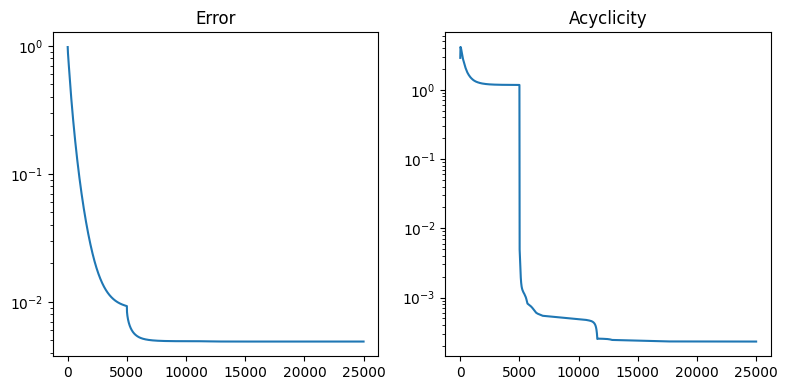

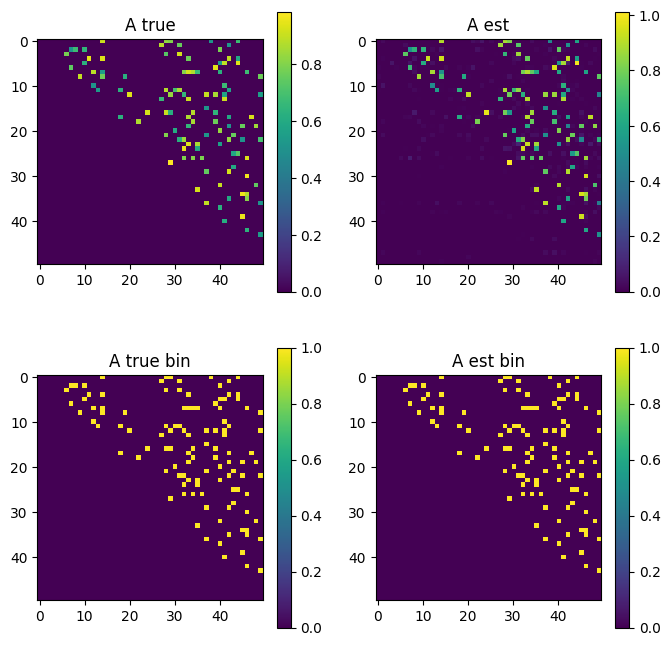

In [6]:
## Second set of hyperparams N = 50
args = {'stepsize': 5e-2, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': .001, 'iters_in': 5000,
        'iters_out': 5, 'verb': True}

print('lamb:', args['lamb'])

t_i = time.time()
model = MetMulDagma()
A_est = model.fit(X, **args, track_seq=True)
t_solved = time.time() - t_i
print(f'Solved in {t_solved:3f} seconds')

# Plot description
thr = .2
plot_convergence(model, A)
plot_result(A, A_est, thr)

## Comparing methods

In [7]:
###  500 samples - 50 nodes #####
N = 50

n_dags = 10
data_params = {
    'n_nodes': N,
    'n_samples': 500, # 1000,
    'graph_type': 'er',
    'edges': 2*N,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'var': 1/np.sqrt(N),
}

Exps = [
    {'model': Nonneg_dagma, 'args': {'stepsize': 5e-2, 'alpha': .1, 's': 1, 'lamb': 1e-3, 'max_iters': 10000},  # TOP!
     'norm_x': False, 'leg': 'PGD-False'},

    {'model': MetMulDagma, 'args': {'stepsize': 1e-1, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': .001,
     'iters_in': 2000, 'iters_out': 5}, 'norm_x': False, 'leg': 'Mult-False'},
    {'model': MetMulDagma, 'args': {'stepsize': 1e-1, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': .001,
     'iters_in': 5000, 'iters_out': 5}, 'norm_x': False, 'leg': 'Mult-False'},
    {'model': MetMulDagma, 'args': {'stepsize': 5e-2, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': .001,
     'iters_in': 5000, 'iters_out': 5}, 'norm_x': False, 'leg': 'Mult-False'},

    {'model': colide_ev, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
     'max_iter': 7e4, 'lr': .0003}, 'norm_x': False, 'leg': 'CoLiDe-Paper_regs-notnorm'},

    # {'model': Nonneg_dagma, 'args': {'stepsize': 5e-1, 'alpha': .005, 's': 1, 'lamb': 1e-5, 'max_iters': 100000}, # TOP
    #  'norm_x': True, 'leg': 'DAGMA-CVX-alpha'},
    # {'model': colide_ev, 'args': {'lambda1': 1e-3, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
    #  'max_iter': 7e4, 'lr': 0.003}, 'norm_x': False,  'leg': 'CoLiDe-norm'},    

]

# shd, fscore, err, acyc, runtime = run_exp(n_dags, data_params, Exps)

print('CPUs employed:', N_CPUS)

t_init = time.time()
results = Parallel(n_jobs=N_CPUS)(delayed(run_exps)(g, data_params, Exps, thr=.2, verb=False) for g in range(n_dags))
ellapsed_time = time.time() - t_init
print(f'----- Solved in {ellapsed_time:.3f} seconds -----')

# Extract results
shd, fscore, err, acyc, runtime = zip(*results)
metrics = {'shd': shd, 'fscore': fscore, 'err': err, 'acyc': acyc, 'time': runtime}


CPUs employed: 32


3: Fidelity: 7.062  -  Fidelity (norm): 0.290
0: Fidelity: 6.958  -  Fidelity (norm): 0.163
9: Fidelity: 7.050  -  Fidelity (norm): 0.187
6: Fidelity: 6.969  -  Fidelity (norm): 0.213
4: Fidelity: 7.088  -  Fidelity (norm): 0.283
2: Fidelity: 6.983  -  Fidelity (norm): 0.306
8: Fidelity: 7.141  -  Fidelity (norm): 0.177
1: Fidelity: 7.128  -  Fidelity (norm): 0.174
5: Fidelity: 7.027  -  Fidelity (norm): 0.149
7: Fidelity: 7.088  -  Fidelity (norm): 0.185


100%|██████████| 130000/130000.0 [00:04<00:00, 28979.23it/s]
100%|██████████| 130000/130000.0 [00:03<00:00, 38554.71it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 31496.85it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 30783.02it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 28763.29it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 28925.90it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 27868.85it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 26888.30it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 25916.11it/s]


----- Solved in 15.747 seconds -----


100%|██████████| 130000/130000.0 [00:05<00:00, 23615.41it/s]


In [8]:
exps_leg = [exp['leg'] for exp in Exps]
utils.display_results(exps_leg, metrics, agg='mean')
utils.display_results(exps_leg, metrics, agg='median')

,leg,shd,fscore,err,acyc,time
0,PGD-False,0.5,0.997313,0.013457,0.010943,1.081332
1,Mult-False,4.0,0.976218,0.034019,0.000488,1.384615
2,Mult-False,3.1,0.981524,0.027472,0.000485,3.440128
3,Mult-False,1.0,0.994271,0.015505,0.000571,3.432624
4,CoLiDe-Paper_regs-notnorm,7.7,0.953639,0.082311,0.000008,4.525426


,leg,shd,fscore,err,acyc,time
0,PGD-False,0.0,1.000000,0.010876,0.005449,1.127892
1,Mult-False,2.5,0.982027,0.029681,0.000526,1.406683
2,Mult-False,1.0,0.990741,0.020044,0.000400,3.484189
3,Mult-False,0.0,1.000000,0.010804,0.000626,3.489621
4,CoLiDe-Paper_regs-notnorm,5.0,0.966175,0.064737,0.000006,4.508128


In [9]:
###  1000 samples - 50 nodes  #####
N = 50

n_dags = 25
data_params = {
    'n_nodes': N,
    'n_samples': 1000, # 1000,
    'graph_type': 'er',
    'edges': 2*N,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'var': 1/np.sqrt(N),
}

Exps = [
    {'model': Nonneg_dagma, 'args': {'stepsize': 5e-2, 'alpha': .1, 's': 1, 'lamb': 1e-3, 'max_iters': 10000},  # TOP!
     'norm_x': False, 'leg': 'DAGMA-CVX-False'},
    {'model': colide_ev, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
     'max_iter': 7e4, 'lr': .0003}, 'norm_x': False, 'leg': 'CoLiDe-Paper_regs-notnorm'},

    {'model': Nonneg_dagma, 'args': {'stepsize': 5e-1, 'alpha': .005, 's': 1, 'lamb': 1e-5, 'max_iters': 100000}, # TOP
     'norm_x': True, 'leg': 'DAGMA-CVX-alpha'},
    {'model': colide_ev, 'args': {'lambda1': 1e-3, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
     'max_iter': 7e4, 'lr': 0.003}, 'norm_x': False,  'leg': 'CoLiDe-norm'},    

]

# shd, fscore, err, acyc, runtime = run_exp(n_dags, data_params, Exps)

print('CPUs employed:', N_CPUS)

t_init = time.time()
results = Parallel(n_jobs=N_CPUS)(delayed(run_exps)(g, data_params, Exps, thr=.2, verb=False) for g in range(n_dags))
ellapsed_time = time.time() - t_init
print(f'----- Solved in {ellapsed_time:.3} seconds -----')

# Extract results
shd, fscore, err, acyc, runtime = zip(*results)
metrics = {'shd': shd, 'fscore': fscore, 'err': err, 'acyc': acyc, 'time': runtime}


CPUs employed: 32
22: Fidelity: 7.130  -  Fidelity (norm): 0.182
23: Fidelity: 7.130  -  Fidelity (norm): 0.159
24: Fidelity: 7.130  -  Fidelity (norm): 0.308
15: Fidelity: 7.120  -  Fidelity (norm): 0.189
0: Fidelity: 7.009  -  Fidelity (norm): 0.109
12: Fidelity: 7.032  -  Fidelity (norm): 0.247
3: Fidelity: 7.039  -  Fidelity (norm): 0.290
20: Fidelity: 7.041  -  Fidelity (norm): 0.421
10: Fidelity: 7.118  -  Fidelity (norm): 0.165
14: Fidelity: 7.065  -  Fidelity (norm): 0.160
9: Fidelity: 7.088  -  Fidelity (norm): 0.222
13: Fidelity: 7.080  -  Fidelity (norm): 0.297
17: Fidelity: 7.079  -  Fidelity (norm): 0.220
16: Fidelity: 6.991  -  Fidelity (norm): 0.365
1: Fidelity: 7.108  -  Fidelity (norm): 0.319
11: Fidelity: 7.056  -  Fidelity (norm): 0.258
5: Fidelity: 7.057  -  Fidelity (norm): 0.222
2: Fidelity: 7.052  -  Fidelity (norm): 0.270
4: Fidelity: 7.051  -  Fidelity (norm): 0.192
18: Fidelity: 7.076  -  Fidelity (norm): 0.369
7: Fidelity: 7.089  -  Fidelity (norm): 0.142
6: 

100%|██████████| 130000/130000.0 [00:03<00:00, 33299.80it/s]
100%|██████████| 130000/130000.0 [00:03<00:00, 37018.28it/s]
100%|██████████| 130000/130000.0 [00:03<00:00, 32934.38it/s]
100%|██████████| 130000/130000.0 [00:03<00:00, 37556.15it/s]
100%|██████████| 130000/130000.0 [00:03<00:00, 34073.39it/s]
100%|██████████| 130000/130000.0 [00:03<00:00, 32916.51it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 25666.17it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 31596.64it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 28099.23it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 27647.83it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 27449.41it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 24506.88it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 26421.06it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 24631.23it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 24771.45it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 24469.14it/s]
100%|██████████| 130000/

----- Solved in 14.8 seconds -----


100%|██████████| 130000/130000.0 [00:02<00:00, 51274.40it/s]
100%|██████████| 130000/130000.0 [00:02<00:00, 46152.01it/s]


In [10]:
# M = 1000
exps_leg = [exp['leg'] for exp in Exps]
utils.display_results(exps_leg, metrics, agg='mean')
utils.display_results(exps_leg, metrics, agg='median')

,leg,shd,fscore,err,acyc,time
0,DAGMA-CVX-False,1.00,0.994682,0.011973,0.048763,1.263801
1,CoLiDe-Paper_regs-notnorm,3.88,0.974004,0.049532,0.000007,4.846653
2,DAGMA-CVX-alpha,3.16,0.981884,0.029408,0.000314,2.827687
3,CoLiDe-norm,16.44,0.911671,0.113045,0.000007,2.252553


,leg,shd,fscore,err,acyc,time
0,DAGMA-CVX-False,0.0,1.000000,0.005452,0.002019,1.264838
1,CoLiDe-Paper_regs-notnorm,3.0,0.976190,0.039694,0.000005,5.141932
2,DAGMA-CVX-alpha,0.0,1.000000,0.015408,0.000114,3.056730
3,CoLiDe-norm,16.0,0.916201,0.113754,0.000006,2.262061


### 1000 samples - 100 nodes

In [11]:
###  1000 samples - 100 nodes  #####
N = 100

n_dags = 25
data_params = {
    'n_nodes': N,
    'n_samples': 1000, # 1000,
    'graph_type': 'er',
    'edges': 2*N,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'var': 1/np.sqrt(N),
}

Exps = [
    {'model': Nonneg_dagma, 'args': {'stepsize': 5e-2, 'alpha': .1, 's': 1, 'lamb': 1e-3, 'max_iters': 10000},  # TOP!
     'norm_x': False, 'leg': 'DAGMA-CVX-False'},
    {'model': colide_ev, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
     'max_iter': 7e4, 'lr': .0003}, 'norm_x': False, 'leg': 'CoLiDe-Paper_regs-notnorm'},

    {'model': Nonneg_dagma, 'args': {'stepsize': 5e-1, 'alpha': .005, 's': 1, 'lamb': 1e-5, 'max_iters': 100000}, # TOP
     'norm_x': True, 'leg': 'DAGMA-CVX-alpha'},
    {'model': colide_ev, 'args': {'lambda1': 1e-3, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
     'max_iter': 7e4, 'lr': 0.003}, 'norm_x': False,  'leg': 'CoLiDe-norm'},    

]

print('CPUs employed:', N_CPUS)

t_init = time.time()
results = Parallel(n_jobs=N_CPUS)(delayed(run_exps)(g, data_params, Exps, thr=.2, verb=False) for g in range(n_dags))
ellapsed_time = time.time() - t_init
print(f'----- Solved in {ellapsed_time:.3} seconds -----')

# Extract results
shd, fscore, err, acyc, runtime = zip(*results)
metrics = {'shd': shd, 'fscore': fscore, 'err': err, 'acyc': acyc, 'time': runtime}


CPUs employed: 32
0: Fidelity: 9.956  -  Fidelity (norm): 0.239
3: Fidelity: 9.956  -  Fidelity (norm): 0.262
1: Fidelity: 9.956  -  Fidelity (norm): 0.239
2: Fidelity: 9.956  -  Fidelity (norm): 0.251
5: Fidelity: 9.956  -  Fidelity (norm): 0.185
4: Fidelity: 9.956  -  Fidelity (norm): 0.302
6: Fidelity: 9.956  -  Fidelity (norm): 0.219
7: Fidelity: 9.956  -  Fidelity (norm): 0.241
9: Fidelity: 9.956  -  Fidelity (norm): 0.252
8: Fidelity: 9.956  -  Fidelity (norm): 0.206
11: Fidelity: 9.956  -  Fidelity (norm): 0.269
10: Fidelity: 9.956  -  Fidelity (norm): 0.245
13: Fidelity: 9.956  -  Fidelity (norm): 0.194
14: Fidelity: 9.956  -  Fidelity (norm): 0.289
12: Fidelity: 9.956  -  Fidelity (norm): 0.235
15: Fidelity: 9.956  -  Fidelity (norm): 0.173
16: Fidelity: 9.956  -  Fidelity (norm): 0.275
17: Fidelity: 9.956  -  Fidelity (norm): 0.166
18: Fidelity: 9.956  -  Fidelity (norm): 0.290
20: Fidelity: 9.956  -  Fidelity (norm): 0.235
19: Fidelity: 9.956  -  Fidelity (norm): 0.260
21: F

100%|██████████| 130000/130000.0 [00:31<00:00, 4130.14it/s] 
100%|██████████| 130000/130000.0 [00:38<00:00, 3376.16it/s] 
100%|██████████| 130000/130000.0 [00:32<00:00, 4039.83it/s]
100%|██████████| 130000/130000.0 [00:35<00:00, 3694.81it/s]
100%|██████████| 130000/130000.0 [00:39<00:00, 3325.20it/s] 
100%|██████████| 130000/130000.0 [00:40<00:00, 3198.55it/s]
100%|██████████| 130000/130000.0 [00:42<00:00, 3082.25it/s]
100%|██████████| 130000/130000.0 [00:45<00:00, 2862.88it/s] 
100%|██████████| 130000/130000.0 [00:49<00:00, 2630.59it/s] 
100%|██████████| 130000/130000.0 [00:12<00:00, 10477.69it/s]
100%|██████████| 130000/130000.0 [00:57<00:00, 2245.66it/s]
100%|██████████| 130000/130000.0 [00:54<00:00, 2381.15it/s] 
100%|██████████| 130000/130000.0 [00:55<00:00, 2328.13it/s] 
100%|██████████| 130000/130000.0 [00:55<00:00, 2363.15it/s]
100%|██████████| 130000/130000.0 [00:54<00:00, 2381.86it/s]
100%|██████████| 130000/130000.0 [00:56<00:00, 2295.72it/s]
100%|██████████| 130000/130000.0

----- Solved in 1.41e+02 seconds -----


100%|██████████| 130000/130000.0 [00:09<00:00, 13752.89it/s]


In [12]:
# M = 1000
exps_leg = [exp['leg'] for exp in Exps]
utils.display_results(exps_leg, metrics, agg='mean')
utils.display_results(exps_leg, metrics, agg='median')

,leg,shd,fscore,err,acyc,time
0,DAGMA-CVX-False,1.92,0.992931,0.011981,0.003113,8.703583
1,CoLiDe-Paper_regs-notnorm,3.60,0.985522,0.033455,0.000007,55.412186
2,DAGMA-CVX-alpha,9.76,0.969100,0.042044,0.000646,24.001604
3,CoLiDe-norm,31.28,0.916179,0.114573,0.000015,15.374925


,leg,shd,fscore,err,acyc,time
0,DAGMA-CVX-False,1.0,0.995122,0.009674,0.002953,9.389734
1,CoLiDe-Paper_regs-notnorm,3.0,0.985294,0.031455,0.000007,55.780066
2,DAGMA-CVX-alpha,9.0,0.970655,0.042703,0.000595,24.033179
3,CoLiDe-norm,30.0,0.916667,0.107138,0.000015,14.591653


### 4N edges

In [13]:
###  1000 samples - 50 nodes  #####
N = 50

n_dags = 25
data_params = {
    'n_nodes': N,
    'n_samples': 1000, # 1000,
    'graph_type': 'er',
    'edges': 4*N,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'var': 1/np.sqrt(N),
}

Exps = [
    {'model': Nonneg_dagma, 'args': {'stepsize': 5e-2, 'alpha': .1, 's': 1, 'lamb': 1e-3, 'max_iters': 10000},  # TOP!
     'norm_x': False, 'leg': 'DAGMA-CVX-False'},
    {'model': colide_ev, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
     'max_iter': 7e4, 'lr': .0003}, 'norm_x': False, 'leg': 'CoLiDe-Paper_regs-notnorm'},

    {'model': Nonneg_dagma, 'args': {'stepsize': 5e-1, 'alpha': .005, 's': 1, 'lamb': 1e-5, 'max_iters': 100000}, # TOP
     'norm_x': True, 'leg': 'DAGMA-CVX-alpha'},
    {'model': colide_ev, 'args': {'lambda1': 1e-3, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
     'max_iter': 7e4, 'lr': 0.003}, 'norm_x': False,  'leg': 'CoLiDe-norm'},    

]

print('CPUs employed:', N_CPUS)

t_init = time.time()
results = Parallel(n_jobs=N_CPUS)(delayed(run_exps)(g, data_params, Exps, thr=.2, verb=False) for g in range(n_dags))
ellapsed_time = time.time() - t_init
print(f'----- Solved in {ellapsed_time:.3} seconds -----')

# Extract results
shd, fscore, err, acyc, runtime = zip(*results)
metrics = {'shd': shd, 'fscore': fscore, 'err': err, 'acyc': acyc, 'time': runtime}


CPUs employed: 32
1: Fidelity: 7.130  -  Fidelity (norm): 0.029
0: Fidelity: 7.130  -  Fidelity (norm): 0.014
2: Fidelity: 7.130  -  Fidelity (norm): 0.022
3: Fidelity: 7.130  -  Fidelity (norm): 0.029
4: Fidelity: 7.130  -  Fidelity (norm): 0.021
6: Fidelity: 7.130  -  Fidelity (norm): 0.019
5: Fidelity: 7.130  -  Fidelity (norm): 0.010
7: Fidelity: 7.130  -  Fidelity (norm): 0.050
9: Fidelity: 7.130  -  Fidelity (norm): 0.019
8: Fidelity: 7.130  -  Fidelity (norm): 0.029
10: Fidelity: 7.130  -  Fidelity (norm): 0.021
11: Fidelity: 7.130  -  Fidelity (norm): 0.036
12: Fidelity: 7.130  -  Fidelity (norm): 0.005
13: Fidelity: 7.130  -  Fidelity (norm): 0.032
14: Fidelity: 7.130  -  Fidelity (norm): 0.029
15: Fidelity: 7.130  -  Fidelity (norm): 0.023
16: Fidelity: 7.130  -  Fidelity (norm): 0.021
17: Fidelity: 7.130  -  Fidelity (norm): 0.007
18: Fidelity: 7.130  -  Fidelity (norm): 0.036
19: Fidelity: 7.130  -  Fidelity (norm): 0.027
20: Fidelity: 7.130  -  Fidelity (norm): 0.029
23: F

100%|██████████| 130000/130000.0 [00:05<00:00, 24778.90it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 26468.91it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 22490.06it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 22087.00it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 24223.57it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 23151.06it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 22870.25it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 22339.09it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 21564.95it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 21202.83it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 20335.61it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 20734.74it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 21007.08it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 20652.70it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 19459.28it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 19003.67it/s]
100%|██████████| 130000/

----- Solved in 39.7 seconds -----


100%|██████████| 130000/130000.0 [00:11<00:00, 11712.72it/s]


In [14]:
exps_leg = [exp['leg'] for exp in Exps]
utils.display_results(exps_leg, metrics, agg='mean')
utils.display_results(exps_leg, metrics, agg='median')

,leg,shd,fscore,err,acyc,time
0,DAGMA-CVX-False,173.60,0.295445,0.909015,10.710553,1.670320
1,CoLiDe-Paper_regs-notnorm,43.60,0.872711,0.215430,0.000078,6.648328
2,DAGMA-CVX-alpha,30.04,0.916756,0.137539,0.000011,14.410765
3,CoLiDe-norm,41.68,0.892816,0.134421,0.000029,7.558120


,leg,shd,fscore,err,acyc,time
0,DAGMA-CVX-False,197.0,0.201613,0.872562,11.269801,1.689354
1,CoLiDe-Paper_regs-notnorm,49.0,0.863415,0.226907,0.000070,6.295152
2,DAGMA-CVX-alpha,17.0,0.946292,0.091704,0.000008,14.972428
3,CoLiDe-norm,37.0,0.903371,0.128555,0.000017,7.397969


In [15]:
###  1000 samples - 100 nodes  #####
N = 100

n_dags = 25
data_params = {
    'n_nodes': N,
    'n_samples': 1000, # 1000,
    'graph_type': 'er',
    'edges': 4*N,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'var': 1/np.sqrt(N),
}

Exps = [
    {'model': Nonneg_dagma, 'args': {'stepsize': 5e-2, 'alpha': .1, 's': 1, 'lamb': 1e-3, 'max_iters': 10000},  # TOP!
     'norm_x': False, 'leg': 'DAGMA-CVX-False'},
    {'model': colide_ev, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
     'max_iter': 7e4, 'lr': .0003}, 'norm_x': False, 'leg': 'CoLiDe-Paper_regs-notnorm'},

    {'model': Nonneg_dagma, 'args': {'stepsize': 5e-1, 'alpha': .005, 's': 1, 'lamb': 1e-5, 'max_iters': 100000}, # TOP
     'norm_x': True, 'leg': 'DAGMA-CVX-alpha'},
    {'model': colide_ev, 'args': {'lambda1': 1e-3, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
     'max_iter': 7e4, 'lr': 0.003}, 'norm_x': False,  'leg': 'CoLiDe-norm'},    

]

# shd, fscore, err, acyc, runtime = run_exp(n_dags, data_params, Exps)

print('CPUs employed:', N_CPUS)

t_init = time.time()
results = Parallel(n_jobs=N_CPUS)(delayed(run_exps)(g, data_params, Exps, thr=.2, verb=False) for g in range(n_dags))
ellapsed_time = time.time() - t_init
print(f'----- Solved in {ellapsed_time:.3} seconds -----')

# Extract results
shd, fscore, err, acyc, runtime = zip(*results)
metrics = {'shd': shd, 'fscore': fscore, 'err': err, 'acyc': acyc, 'time': runtime}


CPUs employed: 32
0: Fidelity: 9.956  -  Fidelity (norm): 0.006
2: Fidelity: 9.956  -  Fidelity (norm): 0.011
1: Fidelity: 9.956  -  Fidelity (norm): 0.014
3: Fidelity: 9.956  -  Fidelity (norm): 0.033
4: Fidelity: 9.956  -  Fidelity (norm): 0.015
7: Fidelity: 9.956  -  Fidelity (norm): 0.020
6: Fidelity: 9.956  -  Fidelity (norm): 0.010
5: Fidelity: 9.956  -  Fidelity (norm): 0.014
8: Fidelity: 9.956  -  Fidelity (norm): 0.023
9: Fidelity: 9.956  -  Fidelity (norm): 0.022
12: Fidelity: 9.956  -  Fidelity (norm): 0.022
11: Fidelity: 9.956  -  Fidelity (norm): 0.009
13: Fidelity: 9.956  -  Fidelity (norm): 0.011
10: Fidelity: 9.956  -  Fidelity (norm): 0.014
14: Fidelity: 9.956  -  Fidelity (norm): 0.018
15: Fidelity: 9.956  -  Fidelity (norm): 0.010
16: Fidelity: 9.956  -  Fidelity (norm): 0.021
17: Fidelity: 9.956  -  Fidelity (norm): 0.019
18: Fidelity: 9.956  -  Fidelity (norm): 0.019
20: Fidelity: 9.956  -  Fidelity (norm): 0.031
19: Fidelity: 9.956  -  Fidelity (norm): 0.025
22: F

  4%|▍         | 5623/130000.0 [00:12<04:57, 417.46it/s]s] 

In [ ]:
# M = 1000
exps_leg = [exp['leg'] for exp in Exps]
utils.display_results(exps_leg, metrics, agg='mean')
utils.display_results(exps_leg, metrics, agg='median')

,leg,shd,fscore,err,acyc,time
0,DAGMA-CVX-False,417.28,0.282983,0.956588,15.445216,13.209178
1,CoLiDe-Paper_regs-notnorm,39.32,0.939098,0.116459,0.000061,146.081003
2,DAGMA-CVX-alpha,81.68,0.882328,0.199845,0.000073,146.320318
3,CoLiDe-norm,78.44,0.898579,0.129781,0.000040,155.222353


,leg,shd,fscore,err,acyc,time
0,DAGMA-CVX-False,407.0,0.190099,0.881961,17.039774,14.672722
1,CoLiDe-Paper_regs-notnorm,39.0,0.939791,0.116373,0.000055,142.695194
2,DAGMA-CVX-alpha,64.0,0.902564,0.155578,0.000074,148.825434
3,CoLiDe-norm,73.0,0.903371,0.122768,0.000040,160.400560
